# Example: Train the spectral neural network model

This notebook demonstrates how to train the spectral neural network model for estimating ocean surface wave spectra from distributed acoustic sensing (DAS) data.  See the `spectral_neural_network.py` module in the `src` folder for the model definition, loss definition, and other helper functions.

In [28]:
# TODO: add ML flow chart here?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import xarray as xr
from torch.utils.data import DataLoader, Subset

from src import das_xarray_helpers
from src import plots
from src import spectral_neural_network
from src import transforms
from src import training_and_inference

Configure PyTorch and define paths. 

In [3]:
DEVICE = 'cpu'
torch.manual_seed(409)

Input data, model weights, and fitted normalizations can be downloaded from Dryad (https://doi.org/10.5061/dryad.brv15dvnz) and should be saved to the `input_data` folder such that it resembles the following structure:

```
input_data/
├── model_states
│   ├── fk_convolutional_neural_network_hyperparameters.pth
│   ├── fk_convolutional_neural_network_model.pth
│   ├── fk_convolutional_neural_network_spectral_feature_norm.pth
│   ├── fk_convolutional_neural_network_target_norm.pth
│   ├── spectral_neural_network_hyperparameters.pth
│   ├── spectral_neural_network_model.pth
│   ├── spectral_neural_network_scalar_feature_norm.pth
│   ├── spectral_neural_network_spectral_feature_norm.pth
│   └── spectral_neural_network_target_norm.pth
├── oliktok_das_mooring_half-hourly_along_cable_dataset.nc
├── oliktok_das_mooring_hourly_along_cable_dataset.nc
├── oliktok_das_mooring_half-hourly_dataset.nc
└── oliktok_das_mooring_hourly_dataset.nc
```


In [4]:
HOURLY_DAS_MOORING_DATA_PATH = 'input_data/oliktok_das_mooring_hourly_dataset.nc'

The Spectral Neural Network model is trained using the hourly DAS-Mooring dataset.

In [5]:
das_60min_ds = xr.open_dataset(HOURLY_DAS_MOORING_DATA_PATH)
das_60min_ds

<xarray.Dataset> Size: 23MB
Dimensions:                                    (time: 215, ch: 183,
                                                frequency: 32)
Coordinates:
  * time                                       (time) datetime64[ns] 2kB 2023...
  * ch                                         (ch) int32 732B 1088 ... 3672
    site                                       (ch) float64 1kB ...
  * frequency                                  (frequency) float64 256B 0.007...
Data variables:
    strain_spectral_density                    (time, ch, frequency) float64 10MB ...
    strain_spectral_density_variance           (time, ch) float64 315kB ...
    cosine_squared_wave_direction              (time, ch) float64 315kB ...
    dist                                       (time, ch) float64 315kB ...
    burial_depth                               (time, ch) float64 315kB ...
    depth                                      (time, ch) float64 315kB ...
    target_seafloor_pressure_spectral_density  (time, ch, frequency) float64 10MB ...
    target_seafloor_pressure_variance          (time, ch) float64 315kB ...
    target_significant_wave_height             (time, ch) float64 315kB ...
    target_energy_period                       (time, ch) float64 315kB ...
    is_train                                   (time) bool 215B ...
    is_test                                    (time) bool 215B ...
Attributes:
    history:        2025-10-17T10:41. Created.
    title:          DAS and seafloor mooring data to accompany the article "N...
    summary:        Hourly DAS features and target mooring variables for all ...
    id:             https://doi.org/10.5061/dryad.brv15dvnz
    license:        CC0
    date_created:   2025-10-17T10:41
    creator_name:   Jacob Davis (UW-APL, WHOI)
    creator_email:  jacob.davis@whoi.edu
    institution:    University of Washington Applied Physics Laboratory (UW-A...
    references:     
    comment:        See accompanying publication in "references" attribute
    _FillValue:     nan

## Data preparation

Split the dataset into training and test sets using the data gap (during cable repairs) as a split point.

In [6]:
# Note gap between 2023-08-30 and 2023-09-17 due to cable repair.
train_period = slice(pd.Timestamp('2023-08-23T12:00'), pd.Timestamp('2023-09-01T00:00'))
test_period = slice(pd.Timestamp('2023-09-17T00:00'), pd.Timestamp('2023-09-21T00:00'))

das_60min_train_ds = das_60min_ds.sel(time=train_period)
das_60min_test_ds = das_60min_ds.sel(time=test_period)

Stack channel (ch) and time dimensions into a single dimension so that feature arrays can be fed sequentially to the model.

In [7]:
das_60min_train_stack_ds = das_xarray_helpers.stack_ch_and_time(das_60min_train_ds)
das_60min_test_stack_ds = das_xarray_helpers.stack_ch_and_time(das_60min_test_ds)

Build the feature and target tensors from the DAS-mooring Dataset. Scalar features (depth, cosine squared wave direction) and spectral features (strain rate spectral density) are concatenated along the second dimension of the feature tensor. The first two elements are depth and cosine squared wave direction, and the remaining 32 entries are strain rate spectral densities in order of increasing frequency. Scalar features, spectral features, and target tensors are transformed separately during this step.

In [8]:
# Strain spectra (features) and pressure spectra (targets) are
# log-transformed to compress their dynamic range. Scalar features
# (depth, direction) are left untransformed.
scalar_feature_transform = None
spectral_feature_transform = transforms.LogTransform()
target_transform = transforms.LogTransform()

# Convert training and test datasets to tensors.
feature_tensor_train = spectral_neural_network.feature_tensor_from_dataset(
    das_ds=das_60min_train_stack_ds,
    scalar_feature_transform=scalar_feature_transform,
    spectral_feature_transform=spectral_feature_transform,
)
target_tensor_train = spectral_neural_network.target_tensor_from_dataset(
    das_ds=das_60min_train_stack_ds,
    target_transform=target_transform,
)

feature_tensor_test = spectral_neural_network.feature_tensor_from_dataset(
    das_ds=das_60min_test_stack_ds,
    scalar_feature_transform=scalar_feature_transform,
    spectral_feature_transform=spectral_feature_transform,
)
target_tensor_test = spectral_neural_network.target_tensor_from_dataset(
    das_ds=das_60min_test_stack_ds,
    target_transform=target_transform,
)

Create training and test PyTorch Datasets from the feature and target tensors.

In [9]:
# Note that the Datasets are initialzied without any normalizations.
# These will be fit and set later.
train_dataset = spectral_neural_network.SpectralNeuralNetworkDataset(
    features=feature_tensor_train,
    targets=target_tensor_train,
)
test_dataset = spectral_neural_network.SpectralNeuralNetworkDataset(
    features=feature_tensor_test,
    targets=target_tensor_test,
)

These return a Tuple of feature and target tensors at the specified index:

In [10]:
idx = 0  # or a slice, e.g. idx = slice(0, 10)
print("train features:\n{} \ntrain targets:\n{}".format(*train_dataset[idx]))
print("test features:\n{} \ntest targets:\n{}".format(*test_dataset[idx]))

train features:
tensor([-5.2739,  0.5468, 12.4540, 12.9061, 12.7044, 12.7416, 12.7217, 12.4657,
        12.3074, 12.5994, 12.5749, 12.1081, 11.8745, 11.4250, 11.0642, 11.1177,
        11.0088, 10.9919, 10.7843, 10.8837, 10.7970, 10.7303, 10.6854, 10.5529,
        10.7038, 10.5356, 10.6227, 10.3432, 10.5046, 10.5148, 10.1940, 10.2427,
        10.4248, 10.3070]) 
train targets:
tensor([ -5.3069,  -5.6134,  -5.7123,  -5.4921,  -4.3422,  -2.9309,  -2.0017,
         -1.5005,  -0.5490,  -1.8379,  -1.7998,  -2.7520,  -2.9378,  -3.0590,
         -3.5590,  -4.2091,  -4.3377,  -5.2939,  -5.8513,  -6.2092,  -7.0675,
         -7.4848,  -7.4831,  -8.5152,  -9.4816,  -9.3154,  -9.4955, -10.0416,
        -10.2470, -10.2243, -11.0786, -11.2578])
test features:
tensor([-5.2806,  0.0429, 12.0580, 12.2012, 12.2890, 12.4255, 12.4635, 12.4518,
        11.9190, 12.0300, 12.0635, 12.0173, 11.6461, 11.4100, 11.0453, 11.0317,
        11.0182, 10.8341, 10.8790, 10.6644, 10.5576, 10.5237, 10.4341, 10.5497,
     

Subset the complete train dataset further into train and validation subsets.  The last period of the train dataset is used for validation during training. Here a Subset is used rather than a separate Dataset to ensure that the same transforms are applied to both the train and validation sets.

In [11]:
val_start = pd.Timestamp('2023-08-28T18:00')
val_end = pd.Timestamp('2023-09-01T00:00')

# Get 'time' level from stacked 'time_ch' index.
train_times = das_60min_train_stack_ds.indexes['time_ch'].get_level_values('time')

train_indices = np.argwhere(
    (train_times <= val_start) |
    (train_times > val_end)
).squeeze()
val_indices = np.argwhere(
    (train_times > val_start) &
    (train_times <= val_end)
).squeeze()

train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(train_dataset, val_indices)

Define and fit min-max normalizers for the feature and target tensors. *Important:* Only the train subset is used to fit the normalizers to prevent data leakage. Normalizations are assigned to the previously created Dataset objects and will be inherited by any Subsets created from these Datasets. A check is performed to ensure that the normalizers are only fit once.

In [12]:
# Define the feature and target normalizations.
scalar_feature_norm = transforms.MinMaxNormalization()
spectral_feature_norm = transforms.MinMaxNormalization()
target_norm = transforms.MinMaxNormalization()

# Check that normalizations have not already been fitted.
if not (train_dataset.any_norms_fitted and test_dataset.any_norms_fitted):
    # Get feature and target tensors for the full train subset.
    feature_tensor_train, target_tensor_train = train_subset[:]

    # Split feature tensor into scalar and spectral components. Here,
    # `start_spec` accounts for the offset of spectral features in the
    # feature tensor.
    start_spec = train_dataset.start_spec
    scalar_feature_tensor = feature_tensor_train[..., 0:start_spec]
    spectral_feature_tensor = feature_tensor_train[..., start_spec:]

    # Fit scalar inputs on a per-feature basis.
    scalar_feature_norm.fit(
        scalar_feature_tensor.reshape(-1, scalar_feature_tensor.shape[-1])
    )

    # Fit spectral features per frequency.
    spectral_feature_norm.fit(
        spectral_feature_tensor.reshape(-1, spectral_feature_tensor.shape[-1])
    )
    target_norm.fit(
        target_tensor_train.reshape(-1, target_tensor_train.shape[-1])
    )

    # Update datasets with fitted normalizations.
    train_dataset.scalar_feature_norm = scalar_feature_norm
    train_dataset.spectral_feature_norm = spectral_feature_norm
    train_dataset.target_norm = target_norm

    test_dataset.scalar_feature_norm = scalar_feature_norm
    test_dataset.spectral_feature_norm = spectral_feature_norm
    test_dataset.target_norm = target_norm

print("normalized train features:\n{} \nnormalized train targets:\n{}".format(*train_dataset[0]))
print("target normalization:\n", train_dataset.target_norm)

normalized train features:
tensor([1.0000, 0.5333, 0.7790, 0.8320, 0.7582, 0.7235, 0.6883, 0.5848, 0.3940,
        0.3346, 0.2360, 0.1794, 0.1942, 0.1274, 0.1977, 0.3279, 0.3993, 0.4620,
        0.4895, 0.5618, 0.5270, 0.4836, 0.4261, 0.3611, 0.3629, 0.3144, 0.3830,
        0.2902, 0.3674, 0.3771, 0.2977, 0.2984, 0.3854, 0.3211]) 
normalized train targets:
tensor([0.8561, 0.7911, 0.7524, 0.8582, 0.9103, 0.8647, 0.7294, 0.7454, 0.9227,
        0.6708, 0.7854, 0.6907, 0.7033, 0.7475, 0.7601, 0.7571, 0.8595, 0.8170,
        0.8250, 0.8221, 0.7661, 0.7799, 0.8165, 0.7486, 0.6901, 0.7673, 0.8002,
        0.7581, 0.7606, 0.8230, 0.6997, 0.6922])
target normalization:
 MinMaxNormalization(
  min_=tensor([ -9.5798, -10.0390,  -9.4566,  -9.5462,  -9.2661,  -9.2073,  -8.3206,
           -7.1418,  -5.4268,  -4.7679,  -5.2480,  -6.1890,  -7.3585,  -8.4488,
           -9.3975, -10.8747, -12.6083, -13.4323, -14.0167, -14.6422, -14.7992,
          -14.5306, -14.2722, -14.3000, -14.6915, -14.4923, -14

## Model training

Define the spectral neural network model's hyperparameters. Here, these are set using the values from the model reported in the manuscript. When applying the model to a new dataset, it is recommended to perform hyperparameter optimization to find the best set of hyperparameters for the new dataset.

In [13]:
hyperparameters = {
    'n_epochs': 50,
    'batch_size': 16,
    'dim_in': 34,
    'n_hidden_layers_1': 16,
    'n_hidden_layers_2': 128,
    'dim_out': 32,
    'lr': 0.000241,
    'beta_1': 0.9571,
    'beta_2': 0.9912,
    'eps': 2.9488e-07,
    'weight_decay': 4.2969e-06,
    'p_dropout': 0.2765,
    'alpha': 0.0288,
}

# Alternatively, load hyperparameters from file:
# HYPERPARAMETERS_PATH = 'input_data/model_states/spectral_neural_network_hyperparameters.pth'
# hyperparameters = torch.load(HYPERPARAMETERS_PATH)

Define the model, optimizer, and loss function from the hyperparameters. The evaluation metric is used as a metric for model selection that is independent from the loss, which may vary depending on the model and hyperparameters. DataLoaders return batches of data from the train and validation subsets during training and are configued to shuffle the order of the input featrues and targets.

In [14]:
model = spectral_neural_network.SpectralNeuralNetwork(
    dim_in=hyperparameters['dim_in'],
    n_hidden_layers_1=hyperparameters['n_hidden_layers_1'],
    n_hidden_layers_2=hyperparameters['n_hidden_layers_2'],
    p_dropout=hyperparameters['p_dropout'],
    dim_out=hyperparameters['dim_out'],
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=hyperparameters['lr'],
    betas=(hyperparameters['beta_1'], hyperparameters['beta_2']),
    eps=hyperparameters['eps'],
    weight_decay=hyperparameters['weight_decay'],
)

loss = spectral_neural_network.SpectralLoss(
    target_norm=target_norm,
    target_transform=target_transform,
    alpha=hyperparameters['alpha'],
)

eval_metric = spectral_neural_network.SpectralEvalMetric(
    target_norm=target_norm,
    target_transform=target_transform,
)

train_subset_loader = DataLoader(
    train_subset,
    batch_size=hyperparameters['batch_size'],
    shuffle=True,
)
val_subset_loader = DataLoader(
    val_subset,
    batch_size=hyperparameters['batch_size'],
    shuffle=True,
)

Train the model.

In [15]:
train_loss, val_loss, train_eval_metrics, val_eval_metrics  = training_and_inference.train_regression_model(
    model=model,
    optimizer=optimizer,
    loss=loss,
    train_loader=train_subset_loader,
    val_loader=val_subset_loader,
    epochs=hyperparameters['n_epochs'],
    eval_metric=eval_metric,
    device=torch.device(DEVICE),
)

  0%|          | 0/50 [00:00<?, ?it/s]

Plot loss curves for the training and validation sets.

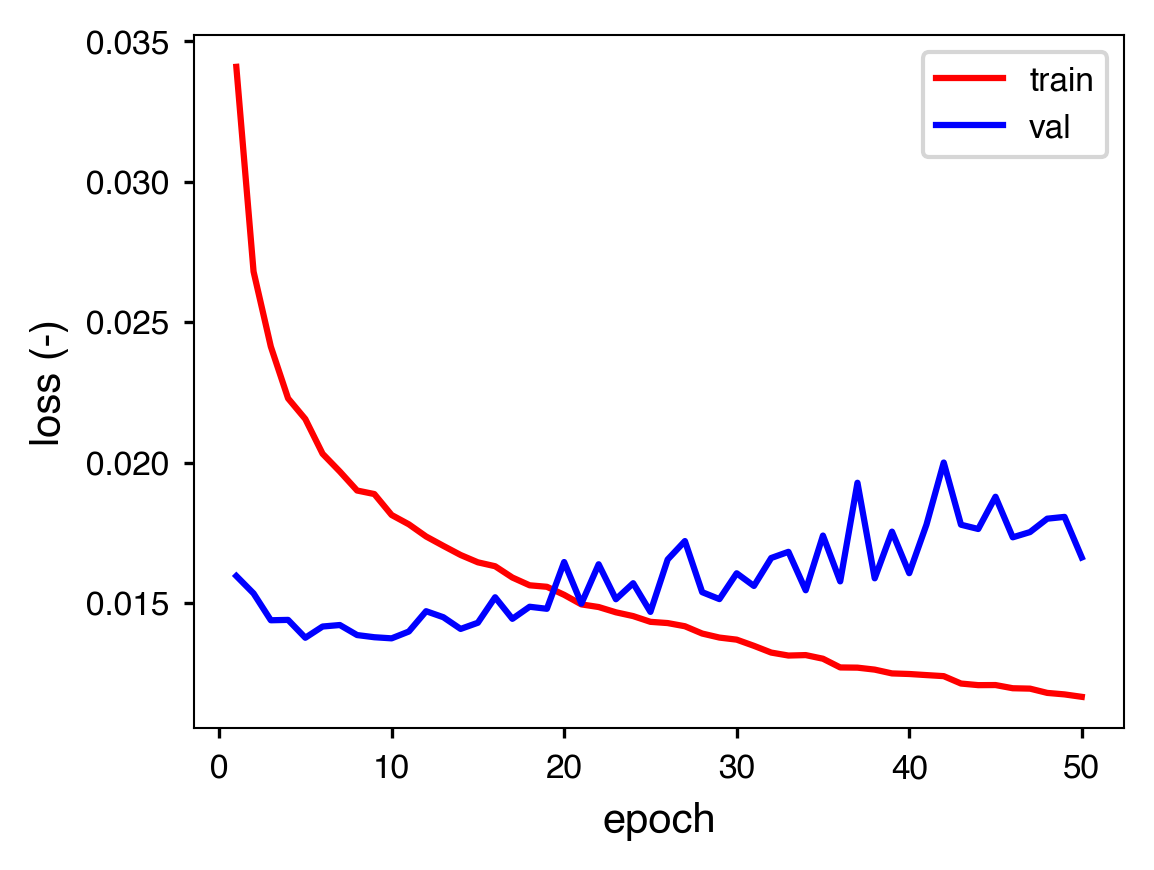

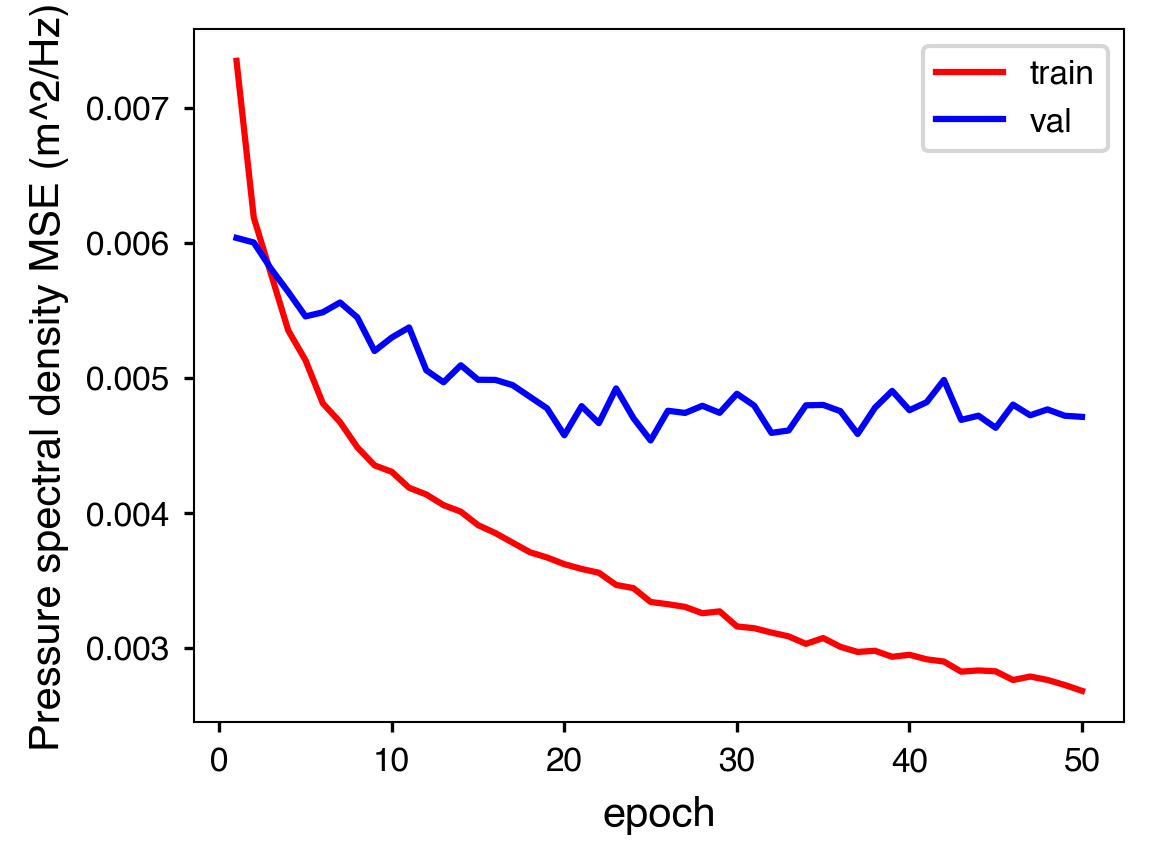

In [27]:
training_iteration = np.arange(1, hyperparameters['n_epochs'] + 1)

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(training_iteration, train_loss, color='r', label='train')
ax.plot(training_iteration, val_loss, color='b', label='val')
ax.set_xlabel('epoch')
ax.set_ylabel('loss (-)')
ax.legend()

# Evaluation metric has physical units and is averaged over all frequencies.
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(training_iteration, train_eval_metrics, color='r', label='train')
ax.plot(training_iteration, val_eval_metrics, color='b', label='val')
ax.set_xlabel('epoch')
ax.set_ylabel('Pressure spectral density MSE (m^2/Hz)')
ax.legend()

## Model predictions

Apply the trained model to the training and validation subsets to generate pressure spectral density predictions. Predictions are unnormalized and inverse transformed (order matters) to physical units (m^2/Hz).

In [20]:
def invert_norm_and_transform(pressure_tensor: torch.Tensor) -> torch.Tensor:
    """Invert norm and transform to return physical pressure spectra. """
    return target_transform.inverse_transform(
        target_norm.inverse_transform(pressure_tensor)
    )

# Load train and vaidation subsets.
feature_tensor_train_subset, target_tensor_train_subset = train_subset[:]
feature_tensor_val_subset, target_tensor_val_subset = val_subset[:]

# Apply the model to each subset.
prediction_tensor_train = training_and_inference.apply_regression_model(model, feature_tensor_train_subset)
prediction_tensor_val = training_and_inference.apply_regression_model(model, feature_tensor_val_subset)

# Inverse transform the model predictions. Normalization must be removed
# before the spectral density log transform is inverted.
prediction_tensor_no_transform_train = invert_norm_and_transform(prediction_tensor_train)
prediction_tensor_no_transform_val = invert_norm_and_transform(prediction_tensor_val)

# Inverse transform the targets.
target_tensor_no_transform_train = invert_norm_and_transform(target_tensor_train_subset)
target_tensor_no_transform_val = invert_norm_and_transform(target_tensor_val_subset)

Plot predicted and target pressure spectral densities for a random sample drawn from the training subset.

Text(0.5, 1.0, 'Example prediction on training subset')

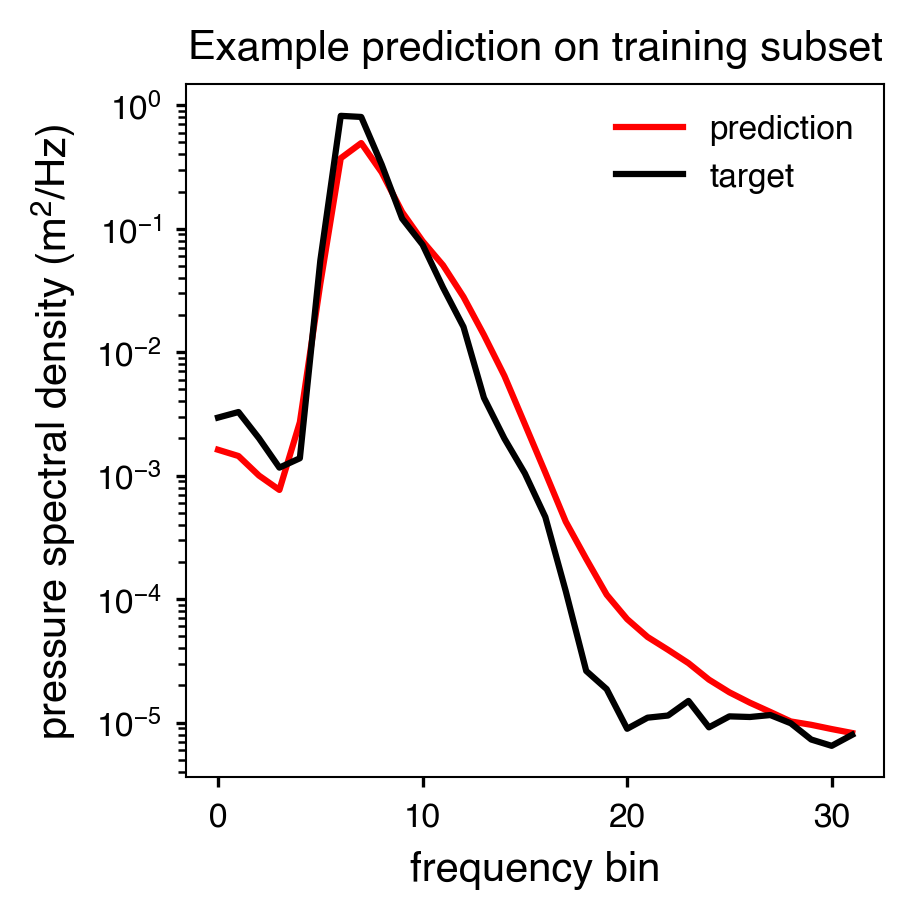

In [25]:
idx = np.random.randint(0, len(prediction_tensor_no_transform_train))

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.plot(prediction_tensor_no_transform_train[idx], color='r', label='prediction')
ax.plot(target_tensor_no_transform_train[idx], color='k', label='target')
ax.set_xlabel('frequency bin')
ax.set_ylabel('pressure spectral density (m$^2$/Hz)')
ax.set_yscale('log')
ax.legend(frameon=False)
ax.set_title('Example prediction on training subset')

Repeat for a random sample drawn from the validation subset.

Text(0.5, 1.0, 'Example prediction on validation subset')

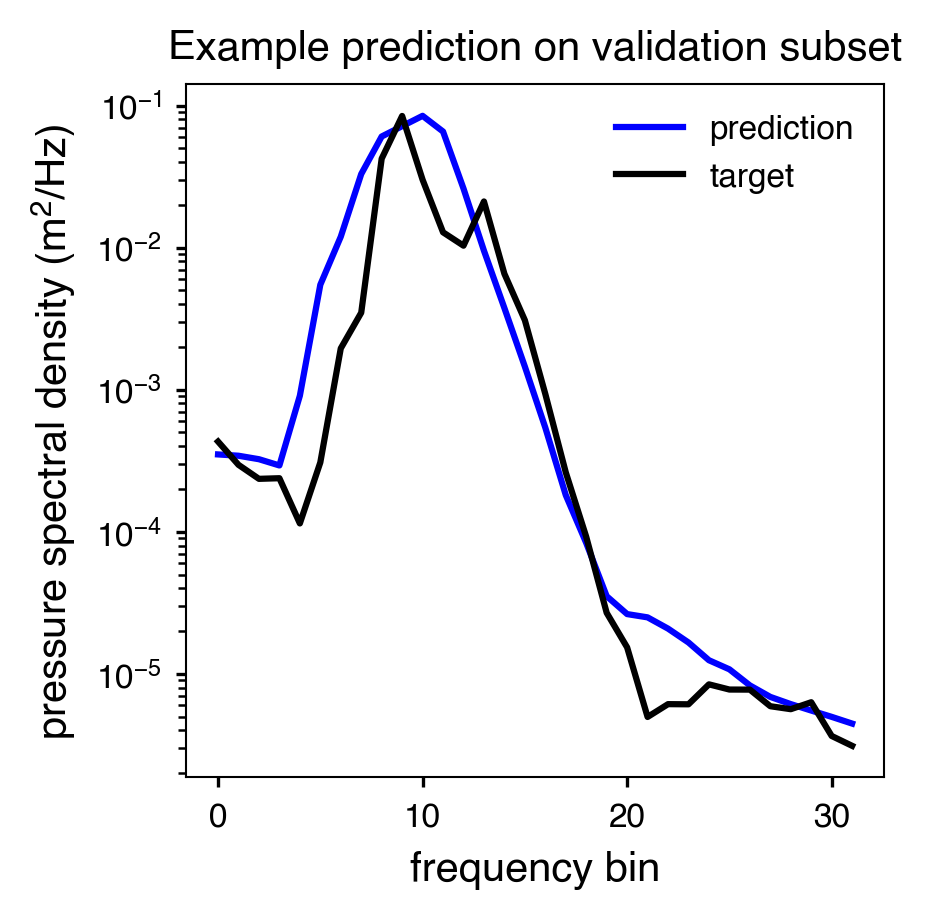

In [24]:
idx = np.random.randint(0, len(prediction_tensor_no_transform_val))

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.plot(prediction_tensor_no_transform_val[idx], color='b', label='prediction')
ax.plot(target_tensor_no_transform_val[idx], color='k', label='target')
ax.set_xlabel('frequency bin')
ax.set_ylabel('pressure spectral density (m$^2$/Hz)')
ax.set_yscale('log')
ax.legend(frameon=False)
ax.set_title('Example prediction on validation subset')

Save the state dictionaries.  If the model will only be used for inference, only the hyperparameters, model state, and norms need to be saved. If further training is planned, the optimizer state dictionary should also be saved.

In [ ]:
# These could also be saved as a dictionary of individual state dicts.
STATE_DICT_DIR = './spectral_neural_network_'

# Save the hyperparameters and model and normalization states for later
# inference only.
torch.save(hyperparameters, STATE_DICT_DIR + 'hyperparameters.pth')
torch.save(model.state_dict(), STATE_DICT_DIR + 'model.pth')
torch.save(scalar_feature_norm.state_dict(), STATE_DICT_DIR + 'scalar_feature_norm.pth')
torch.save(spectral_feature_norm.state_dict(), STATE_DICT_DIR + 'spectral_feature_norm.pth')
torch.save(target_norm.state_dict(), STATE_DICT_DIR + 'target_norm.pth')

# Save the optimizer states to resume training later.
torch.save(optimizer.state_dict(), STATE_DICT_DIR + 'optimizer.pth')

# To load:
# torch.load(STATE_DICT_DIR + 'model.pth')  # etc.

The trained model should be applied to the test subset *only after an optimal model has been chosen* (e.g., using the validation subset).  See `example-apply_spectral_neural_network.ipynb` for a demonstration of how to load the saved model and apply it to new data.